Populating the interactive namespace from numpy and matplotlib



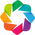

In [1]:
%pylab inline 
import pylab as plt
import holoviews as hv
import geoviews as gv

from bokeh.models import WMTSTileSource
from bokeh.tile_providers import STAMEN_TONER
                                                                                                                                                                                                                                    
from cartopy import crs
from cartopy.io.img_tiles import StamenTerrain
# from cartopy import feature as cf
from geoviews import feature as gf
import pandas as pd
import numpy as np

hv.notebook_extension('bokeh','matplotlib')
%output backend='bokeh'

In [2]:
df = pd.read_pickle('data/traffic_preprocessed.pkl')
# df_inner = pd.read_hdf('data/split_perif_inner.h5','inner')
# df_inner.head()
df.head()

hour  month  id_arc_trafic   AVG(debit)  AVG(taux)  \
id_arc_trafic                                                           
1             0       0      1              1  1188.714286   4.638207   
              93      0      2              1  1261.829268   5.031917   
              186     0      3              1  1468.347826   4.730384   
              79      0      4              1  1106.285714   5.214193   
              165     0      5              1  1452.818182   6.927379   

                         lat       lon   lndebit  time  dlo25  dla25  dlo50  \
id_arc_trafic                                                                 
1             0    48.859838  2.334242  4.121122   100     13     12     25   
              93   48.859838  2.334242  4.170615   200     13     12     25   
              186  48.859838  2.334242  4.298984   300     13     12     25   
              79   48.859838  2.334242  4.062314   400     13     12     25   
              165  48.859838  2.334242  4.289851   500     13     12     25   

                   dla50  dlo75  dla75  
id_arc_trafic                           
1             0       24     38     37  
              93      24     38     37  
              186     24     38     37  
              79      24     38     37  
              165     24     38     37

In [3]:
# df_peri = pd.read_hdf('data/split_perif_inner.h5','periferique')
# df_peri.head()

In [4]:
#coarse graining

def coarse_grain(df):
    df2 = df.groupby(['hour','month','dlo25','dla25']).agg({'AVG(debit)':'sum','AVG(taux)':'mean','lat':'mean','lon':'mean','time':'mean','id_arc_trafic':'max','hour':'mean'})
    df2.columns = df2.columns.get_level_values(0)
    return df2
dfcg = coarse_grain(df)
# dfcg_peri = coarse_grain(df_peri)
# dfcg_inner = coarse_grain(df_inner)
# df2.head()

# or do not coarse grain

# dfcg = df

In [5]:
# tmp = dfcg[dfcg.id_arc_trafic==5512].sort_values('time')[['time','AVG(debit)']]
# plt.plot(tmp['AVG(debit)'].values)
# plt.gca().set_xlim(0,24*6)

In [5]:
def map_counts():
    nodes = dfcg.groupby('time').apply(lambda x:len(x))
    assert(nodes.std()==0.0)
    times =  nodes.shape[0]
    nodes = nodes.max()
    indata = np.zeros((times,nodes),dtype=np.float)

    count = 0

    for inner in dfcg.groupby('time'):
        inner = inner[1]
        indata[count] = inner['AVG(debit)'].values
        count+=1
    return indata,times,nodes
indata,times,nodes = map_counts()

In [6]:
print times,nodes

288 374


## Input for the PCA algorithm

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


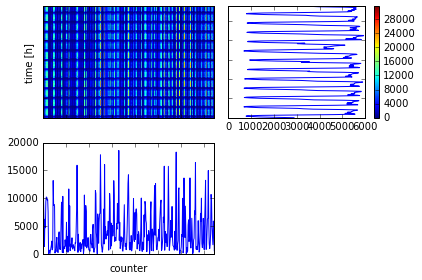

In [7]:
%pylab inline
import pylab as plt
def plotmap(data):
    fig = plt.figure()
    ax = fig.add_subplot(2,2,1)
    bx = fig.add_subplot(2,2,2,sharey=ax)
    cx = fig.add_subplot(2,2,3,sharex=ax)
    
    o=ax.imshow(data,aspect='auto',origin='bottom')
    fig.colorbar(o,ax=bx)
    
    y = data.mean(axis=0)
    x = np.arange(y.shape[0])
    cx.plot(x,y)
    cx.set_xlim(0,x.max())
    y = data.mean(axis=1)
    x = np.arange(y.shape[0])
    bx.plot(y,x)
    bx.set_ylim(0,x.max())
    ax.set_ylabel('time [h]')
    cx.set_xlabel('counter')
    ax.xaxis.set_ticklabels([])
    bx.yaxis.set_ticklabels([])
    fig.tight_layout()
    
plotmap(indata)

## Normalizations

In [8]:
import pma
def normalize(x):
    x =x.copy()
    mean = x.mean()
    var = x.std()
    x-= mean
    x/= var
    return x,mean,var
def normalize_by_ax(x,ax=1):
    x =x.copy()
    mean = x.mean(axis=ax)
    var = x.std(axis=ax)
    if ax==1:
        x=x.T
    x = x - mean
    x = x / var
    if ax==1:
        x=x.T
    return x,mean,var
# data,mean,var = normalize_by_ax(indata,ax=0)

### Simple normalization


$$\tilde C(r_i,t)=C(r_i,t)-\Sigma_i^N\int_0^T dt \frac{C(r_i,t)}{TN}$$
Implyting that $\langle \tilde C(r_i,t)\rangle=0$

average: 0.000000 std: 1.000000


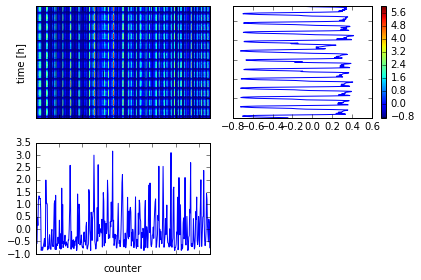

In [10]:
# remove average and set std = 1
data,mean,std = normalize(indata)
plotmap(data)
_,_mean,_std = normalize(data)
print  "average: {0:.6f} std: {1:.6f}".format(_mean,_std)
plt.gcf().savefig('figures/pca_norm_simple.png',bbox_inches='tight',dpi=100)

[ 0.00937752  0.0501027  -0.00011644  0.00477309  0.00083859 -0.00185609
 -0.00316091 -0.00397454  0.00133259 -0.0021874 ]


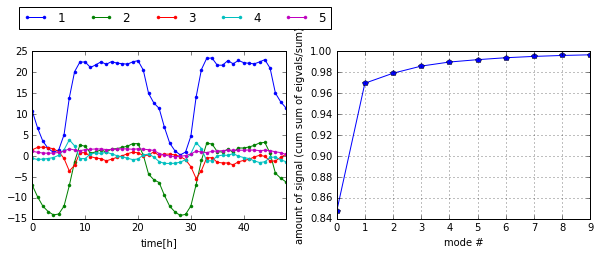

In [11]:
# PCA
pma_out = pma.pma(data)
print pma_out[1][:,:10].mean(axis=0)
# modes aplitude
XY = pma.get_XY(data,pma_out[1][:,:10])
xaxis = np.arange(XY[0].shape[0])

# plot
fig,(ax,bx)=plt.subplots(1,2,figsize=(10,3))
for i,j in enumerate(XY[:5],start=1):
    ax.plot(xaxis,j,'.-',lw=1,label=str(i))
ax.set_xlim(0,48)
ax.set_xlabel('time[h]')
ax.legend(loc='center right',ncol=5,bbox_to_anchor=(1.2, 1.2))

bx.plot(pma_out[0][:10].cumsum()/pma_out[0].sum(),'-p')
bx.grid(1)
bx.set_xlabel('mode #')
bx.set_ylabel('amount of signal (cum sum of eigvals/sum)')

In [12]:
%%output backend='bokeh'
%%opts Overlay [width=int(250) height=int(250) xaxis=None yaxis=None] 
%%opts Points (size=5 cmap='viridis') [tools=['hover'] color_index=2 width=int(250) height=int(250) xaxis=None yaxis=None]

lat = dfcg[dfcg.time==100][['lat']].values
lon = dfcg[dfcg.time==100][['lon']].values

tmp = []
for mode in xrange(7):
    val = pma_out[1][:,mode]
    val = plt.Normalize(vmax=val.mean()+val.std(),vmin=val.mean()-val.std(),clip=1)(val)
    _tmp = [{'lat':la[0],'lon':lo[0],'val':va,'mode':mode} for la,lo,va in  zip(lat,lon,val)]
    tmp.extend(_tmp)
modes = pd.DataFrame(columns=['lat','lon','val','mode'],data=tmp)


def msum(x):
    out = x.next()
    for j in x:
        out += j
    return out

keys = ['lat','lon','val']
counters = ( gv.Dataset(modes[modes['mode']==j][keys]).to(gv.Points, kdims=['lon', 'lat'],
                    vdims='val', crs=crs.PlateCarree()) for j in xrange(4))
# mgeo = gv.WMTS(WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
#        crs=crs.epsg(2154))
# layout =  mgeo*counters.next()
# for j in counters:
#     layout += mgeo*j

layout = counters.next()
for j in counters:
    layout += j 
    
layout

:Layout
   .Points.I   :Points   [lon,lat]   (val)
   .Points.II  :Points   [lon,lat]   (val)
   .Points.III :Points   [lon,lat]   (val)
   .Points.IV  :Points   [lon,lat]   (val)

### Normalize each counter
Same as removing temporal trend and study **flutuations**

$$\tilde C(r_i,t)=C(r_i,t)-\Sigma_i^N \frac{C(r_i,t)}{N}$$
Implyting that $\langle \tilde C(r_i,t)\rangle_{t}=0$

288 288 374


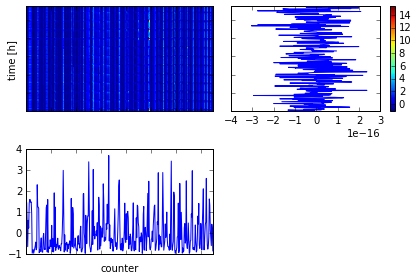

In [9]:
data,mean,var = normalize_by_ax(indata,ax=1)
print mean.shape[0],times,nodes
plotmap(data)
plt.gcf().savefig('figures/pca_norm_time.png',bbox_inches='tight',dpi=100)

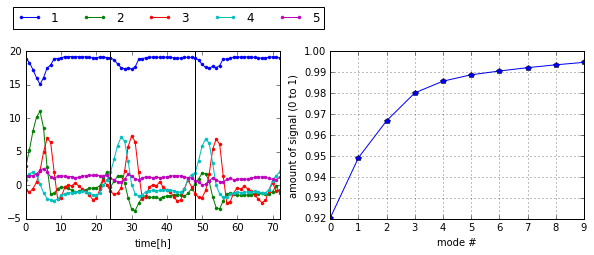

In [23]:
# PCA
pma_out = pma.pma(data)

# modes aplitude
XY = pma.get_XY(data,pma_out[1][:,:10])
xaxis = np.arange(XY[0].shape[0])

# plot
fig,(ax,bx)=plt.subplots(1,2,figsize=(10,3))
for i,j in enumerate(XY[:5],start=1):
    ampl_sign = np.sign(j.mean())
    j=j.copy()
    j*=ampl_sign
    ax.plot(xaxis,j,'.-',lw=1,label=str(i))
N = 3
H = 24
ax.set_xlim(0,N*H)
for j in range(1,N):
    ax.axvline(j*H,lw=1,c='k')
ax.set_xlabel('time[h]')
ax.legend(loc='center right',ncol=5,bbox_to_anchor=(1.2, 1.2))

bx.plot(pma_out[0][:10].cumsum()/pma_out[0].sum(),'-p')
bx.grid(1)
bx.set_xlabel('mode #')
bx.set_ylabel('amount of signal (0 to 1)')
plt.gcf().savefig('figures/pca_norm_ampli.png',bbox_inches='tight',dpi=100)

### First eigenmodes

In [25]:
lat = dfcg[dfcg.time==100][['lat']].values
lon = dfcg[dfcg.time==100][['lon']].values

tmp = []
for mode in xrange(7):
    amplitude = XY[mode]
    sign = np.sign(amplitude.mean())
    val = pma_out[1][:,mode]*sign
    val = plt.Normalize(vmax=val.mean()+val.std(),vmin=val.mean()-val.std(),clip=1)(val)
    _tmp = [{'lat':la[0],'lon':lo[0],'val':va,'mode':mode} for la,lo,va in  zip(lat,lon,val)]
    tmp.extend(_tmp)
modes = pd.DataFrame(columns=['lat','lon','val','mode'],data=tmp)

In [27]:
# %%output backend='bokeh'
# %%opts Overlay [width=int(250) height=int(250) xaxis=None yaxis=None] 
# %%opts Points (size=5 cmap='viridis') [tools=['hover'] color_index=2 width=int(250) height=int(250) xaxis=None yaxis=None]

# def msum(x):
#     out = x.next()
#     for j in x:
#         out += j
#     return out

# keys = ['lat','lon','val']
# counters = ( gv.Dataset(modes[modes['mode']==j][keys]).to(gv.Points, kdims=['lon', 'lat'],
#                     vdims='val', crs=crs.PlateCarree()) for j in xrange(4))
# mgeo = gv.WMTS(WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
#        crs=crs.epsg(2154))
# # layout =  mgeo*counters.next()
# # for j in counters:
# #     layout += mgeo*j

# layout = counters.next()
# for j in counters:
#     layout += j 
    
# layout

#### Save modes  with matplotlib

In [28]:
modes.lat.max()

48.901670197999998

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'mean', 'sign', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


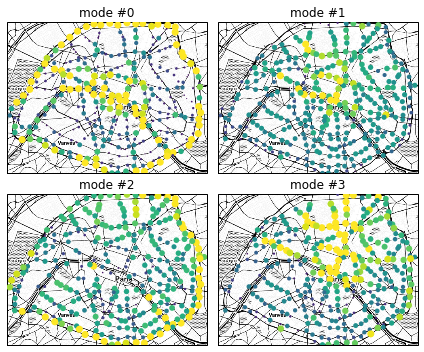

In [29]:
%pylab inline
from matplotlib.font_manager import FontProperties
from cartopy.io.img_tiles import OSM,StamenTerrain,GoogleTiles
from scipy.interpolate import griddata
from tqdm import tqdm_notebook as tqdm
font0 = FontProperties()
font0.set_family('serif')
font0.set_name('ubuntu')
class StamenToner(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/toner/{}/{}/{}.png'.format(z, x, y)
        return url
    
imagery = OSM()
imagery = StamenToner()

fig, axs = plt.subplots(2,2,figsize=(6, 5),subplot_kw=dict(projection=imagery.crs))
axs= axs.flatten()

minLO = modes.lon.min()*0.999
maxLO = modes.lon.max()*1.001
minLA = modes.lat.min()
maxLA = modes.lat.max()
modes_to_plot = [ modes[modes['mode']==j] for j,i in enumerate(axs)]
for i,(ax,stuff) in enumerate(zip(axs,modes_to_plot)):
    ax.set_extent((minLO,maxLO,minLA,maxLA))
    ax.add_image(imagery, 12)
    xs,ys,vs = stuff[['lon','lat','val']].values.T
    ax.scatter(xs, ys, transform=crs.PlateCarree(), c=plt.cm.viridis(vs), s=vs*50,lw=0,zorder=11)
    ax.set_title("mode #{0:d}".format(i))
    
fig.tight_layout()
fig.savefig('figures/map_modes.png',bbox_inches='tight',dpi=100)

### Reconstruct from first 4 modes

In [30]:
sel_modes=slice(0,7)
new04 = pma.reconstruc_frommodes(pma_out[1][:,sel_modes],XY[sel_modes])
sel_modes=slice(1,7)
new14 = pma.reconstruc_frommodes(pma_out[1][:,sel_modes],XY[sel_modes])
# print new.shape

#### Prepare dataframe for to compare modes

In [41]:
lat = dfcg[dfcg.time==100][['lat']].values
lon = dfcg[dfcg.time==100][['lon']].values
ftime = lambda t:100*(t//24+1)+(t-t//24*24) # encode time as an increasing number: (month*100+hour)
def makedf(new):
    tmp = []
    vmean = new.mean()
    vstd  = new.std()
    for time in xrange(new.shape[0]):
        val = new[time]
        val = plt.Normalize(vmax=vmean+vstd,vmin=vmean-vstd,clip=1)(val)
        _tmp = [{'lat':la[0],'lon':lo[0],'val':va,'time':ftime(time)} for la,lo,va in  zip(lat,lon,val)]
        tmp.extend(_tmp)
    new_pd = pd.DataFrame(columns=['lat','lon','val','time'],data=tmp)
    return new_pd

new04=makedf(new04)
new14=makedf(new14)

In [42]:
# %%output backend='bokeh'
# %%opts Overlay [width=int(250) height=int(250) xaxis=None yaxis=None] 
# %%opts Points (size=5 cmap='viridis') [tools=['hover'] color_index=2 width=int(250) height=int(250) xaxis=None yaxis=None]

# counters04 = gv.Dataset(new04,kdims=['time',]).to(gv.Points, kdims=['lon', 'lat'],
#                     vdims='val', crs=crs.PlateCarree())
# counters14 = gv.Dataset(new14,kdims=['time',]).to(gv.Points, kdims=['lon', 'lat'],
#                     vdims='val', crs=crs.PlateCarree())

# #mgeo = gv.WMTS(WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
#        crs=crs.epsg(2154))

# #layout =mgeo*counters04+mgeo*counters14
# layout =counters04+counters14
# layout


## Summary

The 1st mode dominates, so the left plot can barely show the dinamics which is developped beside the oscillations of the periferique. In the right plot the the 1st mode is factored out, thus that we see the remaining dynamics which, *per se*, is unexpected.

Note that the visualization is a bit amplified becasue every value beyond 1$\sigma$ is clipped to the maximum value.

The PCA of the counters normalied about each counter mean value would give a similar information, but the modes are less transparent to the interpretation

## Save as movie

In [43]:
%pylab inline
from matplotlib.font_manager import FontProperties
from cartopy.io.img_tiles import OSM,StamenTerrain,GoogleTiles
from scipy.interpolate import griddata
from tqdm import tqdm_notebook as tqdm
font0 = FontProperties()
font0.set_family('serif')
font0.set_name('ubuntu')
class StamenToner(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/toner/{}/{}/{}.png'.format(z, x, y)
        return url
    
imagery = OSM()
imagery = StamenToner()

Populating the interactive namespace from numpy and matplotlib


In [44]:
dest='pca_frames/'

In [45]:
!mkdir $dest/combined -p

In [46]:
fig, (ax,bx) = plt.subplots(1,2,figsize=(12, 6),subplot_kw=dict(projection=imagery.crs))
minLO = min(new04.lon.min(),new14.lon.min())
maxLO = max(new04.lon.max(),new14.lon.max())
minLA = min(new04.lat.min(),new14.lat.min())
maxLA = max(new04.lat.max(),new14.lat.max())
ax.set_extent((minLO,maxLO,minLA,maxLA))
bx.set_extent((minLO,maxLO,minLA,maxLA))
# # # Add the imagery to the map.
ax.add_image(imagery, 12)
bx.add_image(imagery, 12)

fig.savefig(dest+'/mapST.png',bbox_inches='tight',dpi=96)
plt.close();

In [47]:
np.alltrue(new14.time.unique()==new04.time.unique())

True

In [48]:
import os

In [55]:
month_names="January February March April May June July August September October November December".split(" ")
fig, (ax,bx) = plt.subplots(1,2,figsize=(12, 6),subplot_kw=dict(projection=imagery.crs))
minLO = min(new04.lon.min(),new14.lon.min())
maxLO = max(new04.lon.max(),new14.lon.max())
minLA = min(new04.lat.min(),new14.lat.min())
maxLA = max(new04.lat.max(),new14.lat.max())
extent = (minLO,maxLO,minLA,maxLA)
ax.set_extent(extent)
bx.set_extent(extent)

times = new14.time.unique()

for time in tqdm(sorted(times)):
    for data,axes in ((new04,ax),(new14,bx)):
        dftimed = data[data.time==time]
        month = time//100
        hour  = time - month*100
        xs,ys,vs = dftimed[['lon','lat','val']].values.T
    #     xi_x,xi_y = np.mgrid[DLO[0]:DLO[1]:100j,DLA[0]:DLA[1]:100j]
    #     vs = norm(vs)
    #     vi = griddata(zip(xs,ys),vs,(xi_x,xi_y),method='linear').T
    #     vs = plt.Normalize()(vs)

    #     ax.imshow(vi,extent=extent,
    #               transform=crs.PlateCarree(),cmap=plt.cm.jet,
    #               alpha=.25,zorder=10)

        axes.scatter(xs, ys, transform=crs.PlateCarree(), c=plt.cm.jet(vs), s=vs*200,lw=0,zorder=11)

        # make invisibility coat for the background
        axes.outline_patch.set_visible(False)
        axes.background_patch.set_visible(False)
        axes.set_extent(extent)
#  bbox=dict(facecolor='w', alpha=0.75),
    when = "{1:.0f}:00\n{0:s}".format(month_names[month-1],hour)
#     print when
    bx.text(-0.1,0.5,when,
            fontsize=18, transform=bx.transAxes,va='center',ha='center',
           fontproperties=font0,zorder=11)
    ax.text(0,0,"Copyright (C) 2017 Guglielmo Saggiorato - map: Stamen Toner - data: opendata.paris.fr",fontsize=10,
           fontproperties=font0,transform=ax.transAxes,va='bottom',ha='left',zorder = 12)
        
    fout = 'fr{0:04d}'.format(time)
    fig.savefig(dest+'/{0:s}.png'.format(fout),bbox_inches='tight',dpi=96,transparent=True)

    os.system('convert {1:s}/mapST.png {1:s}/{0:s}.png -layers merge {1:s}/combined/{0:s}.jpg'.format(fout,dest))
    ax.cla()
    bx.cla()
plt.close();
cmd = "rm {fout:s}; cat {indir:s}/*.jpg | ffmpeg -f image2pipe -r {rate:d} -i - -vf scale={xscale:d}:-1 -c:v libvpx-vp9 -b:v 2M {fout:s}"
cm = cmd.format(fout='pca.webm',indir=dest+'/combined/',rate=4,xscale=640)
os.system(cm)

A Jupyter Widget

0

In [56]:
%%HTML
<center>
<video width="640"  controls>
  <source src="pca.webm" type="video/webm">
</video>
</center>
<a href=pca.webm target=_blank>pca.webm</a>